In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import time

# read files

In [24]:
inputs = pd.read_pickle("Data/Sampled_inputs3.pck")
labels = pd.read_pickle("Data/Sampled_labels3.pck")

In [25]:
len(inputs)

3600

In [26]:
inputs.shape

(3600, 60, 33)

# check NAN

In [27]:
if np.isnan(inputs).any():
  print('oops')

In [28]:
len(labels)

3600

# classes distribution

In [29]:
from collections import Counter
label_count = Counter(labels)
label_count

Counter({1: 1200, 0: 600, 2: 600, 3: 600, 4: 600})

# generate binary labels

In [30]:
labels = np.where(labels == 0, 1, labels)

labels = np.where(((labels == 2)|(labels ==3)|(labels ==4)), 0, labels)
print(labels)

[1 1 1 ... 0 0 0]


# balanced dataset

In [31]:
from collections import Counter
label_count = Counter(labels)
label_count

Counter({1: 1800, 0: 1800})

# data prepare: transpose

In [32]:
inputs = inputs.transpose(0,2,1)
inputs.shape

(3600, 33, 60)

# feature selection for univariate time sereies classification

In [33]:
#return the i-th feature as input 
def feature_select(input,i):
  feature = input[:,i,:]
  feature = feature.reshape(feature.shape[0],1,feature.shape[1])
  return feature

# train, test split and z-normalize

In [34]:
#train_test split and normalize
def data_prepare(inputs, labels):
  X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=42)
  X_train_mean = X_train.mean()
  X_train_std = X_train.std()
  X_train = (X_train - X_train_mean)/X_train_std
  X_test = (X_test - X_train_mean)/X_train_std
  return X_train, X_test, y_train, y_test


In [35]:
! pip install sktime

Defaulting to user installation because normal site-packages is not writeable


#the index of top 10 important parameters

In [36]:
keys = [4, 24, 5, 1, 23, 25, 26, 2, 17, 3]

# select n features for multivariate time series classification

In [37]:
#return the n_feature as input 
def feature_select_n(input,i):
  feature = input[:,i,:]
  return feature

# multivariate-interval based (Canonical Interval Forest (CIF))


In [38]:
! pip install catch22

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement catch22 (from versions: 0.2.1)
ERROR: No matching distribution found for catch22


In [39]:
from sktime.classification.interval_based._cif import CanonicalIntervalForest

In [40]:
import time
times = []
top_k_accuracy = []
top_k_f1 = []
top_k_recall = []
top_k_precision = []
top_k_tss = []
for i in range(1,len(keys)+1):
  data = feature_select_n(inputs,keys[:i])
  X_train, X_test, y_train, y_test = data_prepare(data, labels)
  print(X_train.shape)
  stime = time.time()
  cif_m = CanonicalIntervalForest(n_estimators=10, att_subsample_size=8, random_state=47)
  cif_m.fit(X_train, y_train)
  y_pred = cif_m.predict(X_test)
  time_consume = time.time() - stime
  times.append(time_consume)
  top_k_accuracy.append(accuracy_score(y_test,y_pred))
  top_k_f1.append(f1_score(y_test, y_pred, average='micro'))
  top_k_recall.append(recall_score(y_test, y_pred, average='micro'))
  top_k_precision.append(precision_score(y_test, y_pred, average='micro'))
  TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
  tss = (TP / (TP + FN)) - (FP / (FP + TN))
  top_k_tss.append(tss)

print("top_k_accuracy: ", top_k_accuracy) 
print("top_k_f1: ", top_k_f1)
print("top_k_recall: ", top_k_recall)
print("top_k_precision: ", top_k_precision)
print("top_k_tss: ", top_k_tss)
print("consumed time: ", times)

(2700, 1, 60)


(2700, 2, 60)
(2700, 3, 60)
(2700, 4, 60)
(2700, 5, 60)
(2700, 6, 60)
(2700, 7, 60)
(2700, 8, 60)
(2700, 9, 60)
(2700, 10, 60)
top_k_accuracy:  [0.8455555555555555, 0.8655555555555555, 0.8533333333333334, 0.8466666666666667, 0.8644444444444445, 0.85, 0.8422222222222222, 0.8011111111111111, 0.8344444444444444, 0.8022222222222222]
top_k_f1:  [0.8455555555555555, 0.8655555555555555, 0.8533333333333334, 0.8466666666666667, 0.8644444444444445, 0.85, 0.8422222222222222, 0.8011111111111111, 0.8344444444444444, 0.8022222222222222]
top_k_recall:  [0.8455555555555555, 0.8655555555555555, 0.8533333333333334, 0.8466666666666667, 0.8644444444444445, 0.85, 0.8422222222222222, 0.8011111111111111, 0.8344444444444444, 0.8022222222222222]
top_k_precision:  [0.8455555555555555, 0.8655555555555555, 0.8533333333333334, 0.8466666666666667, 0.8644444444444445, 0.85, 0.8422222222222222, 0.8011111111111111, 0.8344444444444444, 0.8022222222222222]
top_k_tss:  [0.6892879256965945, 0.7276780185758513, 0.703281733

In [41]:
cif = [0.8444, 0.8444, 0.8444, 0.8444, 0.6852, 14.2692]

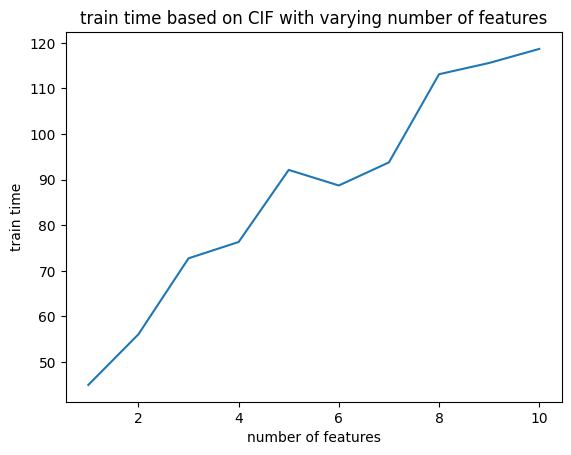

In [42]:
import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,7,8,9,10]
plt.title('train time based on CIF with varying number of features')
plt.xlabel('number of features')
plt.ylabel('train time')
plt.plot(x,times)

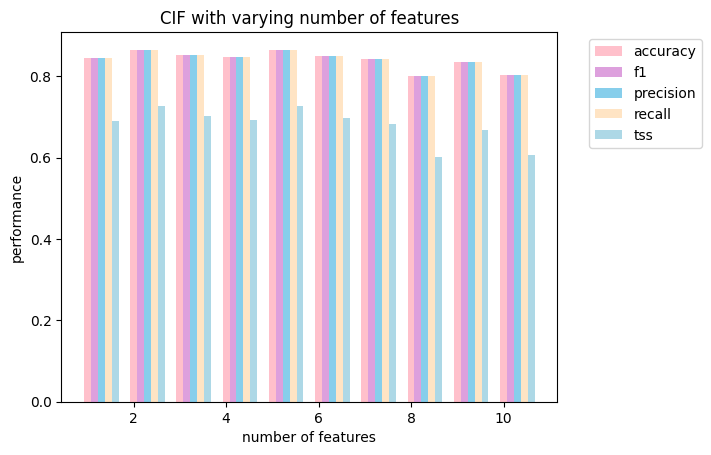

In [43]:
data = [top_k_accuracy,
  top_k_f1,
  top_k_precision,
  top_k_recall,
  top_k_tss]

X = np.arange(1,11)
plt.bar(X + 0.00, data[0], color = 'pink', width = 0.15)
plt.bar(X + 0.15, data[1], color = 'plum', width = 0.15)
plt.bar(X + 0.30, data[2], color = 'skyblue', width = 0.15)
plt.bar(X + 0.45, data[3], color = 'bisque', width = 0.15)
plt.bar(X + 0.60, data[4], color = 'lightblue', width = 0.15)
plt.title('CIF with varying number of features')
plt.xlabel('number of features')
plt.ylabel('performance')
plt.legend(["accuracy", "f1", "precision", "recall","tss"],bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Dictionat-based (Word extraction for time series classification + Multivariate Unsupervised symbols and Derivatives (WEASEL + MUSE ))

In [44]:
from sktime.classification.dictionary_based import MUSE, WEASEL

In [45]:
import time
times = []
top_k_accuracy = []
top_k_f1 = []
top_k_recall = []
top_k_precision = []
top_k_tss = []
data = feature_select(inputs,4)
X_train, X_test, y_train, y_test = data_prepare(data, labels)
print(X_train.shape)
stime = time.time()
weasel = WEASEL(binning_strategy="equi-depth", anova=False, random_state=47)
weasel.fit(X_train, y_train)
y_pred = weasel.predict(X_test)
time_consume = time.time() - stime
times.append(time_consume)
top_k_accuracy.append(accuracy_score(y_test,y_pred))
top_k_f1.append(f1_score(y_test, y_pred, average='micro'))
top_k_recall.append(recall_score(y_test, y_pred, average='micro'))
top_k_precision.append(precision_score(y_test, y_pred, average='micro'))
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
tss = (TP / (TP + FN)) - (FP / (FP + TN))
top_k_tss.append(tss)

print("top_k_accuracy: ", top_k_accuracy) 
print("top_k_f1: ", top_k_f1)
print("top_k_recall: ", top_k_recall)
print("top_k_precision: ", top_k_precision)
print("top_k_tss: ", top_k_tss)
print("consumed time: ", times)

(2700, 1, 60)
top_k_accuracy:  [0.91]
top_k_f1:  [0.91]
top_k_recall:  [0.91]
top_k_precision:  [0.91]
top_k_tss:  [0.8168421052631579]
consumed time:  [42.892818450927734]


In [46]:
import time
for i in range(2,len(keys)+1):
  data = feature_select_n(inputs,keys[:i])
  X_train, X_test, y_train, y_test = data_prepare(data, labels)
  print(X_train.shape)
  stime = time.time()
  muse = MUSE()
  muse.fit(X_train, y_train)
  y_pred = muse.predict(X_test)
  time_consume = time.time() - stime
  times.append(time_consume)
  top_k_accuracy.append(accuracy_score(y_test,y_pred))
  top_k_f1.append(f1_score(y_test, y_pred, average='micro'))
  top_k_recall.append(recall_score(y_test, y_pred, average='micro'))
  top_k_precision.append(precision_score(y_test, y_pred, average='micro'))
  TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
  tss = (TP / (TP + FN)) - (FP / (FP + TN))
  top_k_tss.append(tss)

print("top_k_accuracy: ", top_k_accuracy) 
print("top_k_f1: ", top_k_f1)
print("top_k_recall: ", top_k_recall)
print("top_k_precision: ", top_k_precision)
print("top_k_tss: ", top_k_tss)
print("consumed time: ", times)

(2700, 2, 60)


: 

In [ ]:
weasel_muse = [0.9211, 0.9211, 0.9211, 0.9211, 0.8383, 122]

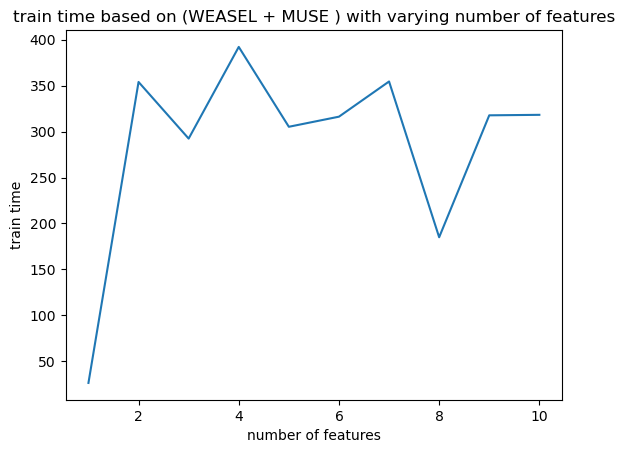

In [ ]:
x = [1,2,3,4,5,6,7,8,9,10]
plt.title('train time based on (WEASEL + MUSE ) with varying number of features')
plt.xlabel('number of features')
plt.ylabel('train time')
plt.plot(x,times)

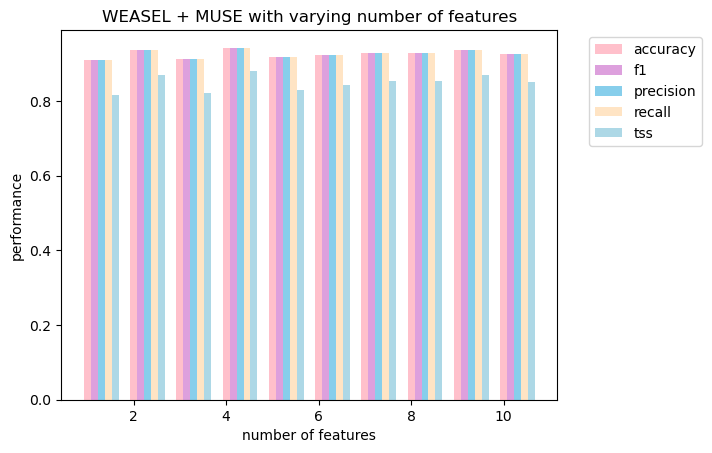

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = [top_k_accuracy,
  top_k_f1,
  top_k_precision,
  top_k_recall,
  top_k_tss]

X = np.arange(1,11)
plt.bar(X + 0.00, data[0], color = 'pink', width = 0.15)
plt.bar(X + 0.15, data[1], color = 'plum', width = 0.15)
plt.bar(X + 0.30, data[2], color = 'skyblue', width = 0.15)
plt.bar(X + 0.45, data[3], color = 'bisque', width = 0.15)
plt.bar(X + 0.60, data[4], color = 'lightblue', width = 0.15)
plt.title('WEASEL + MUSE with varying number of features')
plt.xlabel('number of features')
plt.ylabel('performance')
plt.legend(["accuracy", "f1", "precision", "recall","tss"],bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
cif

[0.8444, 0.8444, 0.8444, 0.8444, 0.6852, 14.2692]

In [ ]:
weasel_muse

[0.9211, 0.9211, 0.9211, 0.9211, 0.8383, 122]

In [ ]:
accuracy = [0.8444, 0.9211]
precision = [0.8444, 0.9211]
recall = [0.8444, 0.9211]
f1 = [0.8444, 0.9211]
tss = [0.6852, 0.8383]
time = [14, 122]

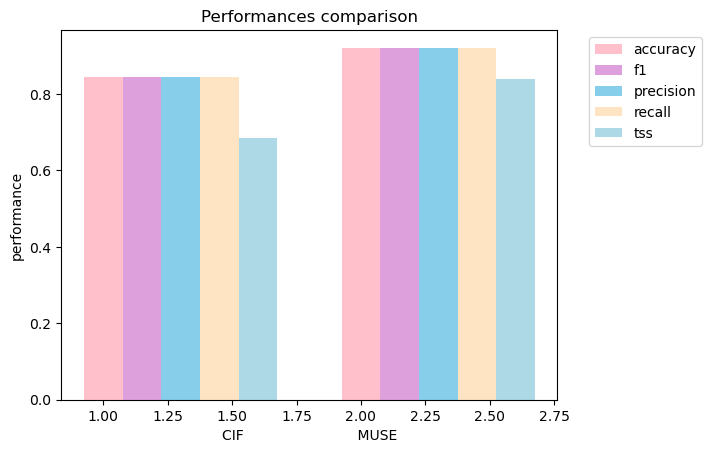

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = [accuracy,
  precision,
  recall,
  f1,
  tss,
  time]

X = np.arange(1,3)
plt.bar(X + 0.00, data[0], color = 'pink', width = 0.15)
plt.bar(X + 0.15, data[1], color = 'plum', width = 0.15)
plt.bar(X + 0.30, data[2], color = 'skyblue', width = 0.15)
plt.bar(X + 0.45, data[3], color = 'bisque', width = 0.15)
plt.bar(X + 0.60, data[4], color = 'lightblue', width = 0.15)
# plt.bar(X + 0.75, data[5], color = 'black', width = 0.15)

plt.title('Performances comparison')
plt.xlabel("CIF                          MUSE")
plt.ylabel('performance')
plt.legend(["accuracy", "f1", "precision", "recall","tss"],bbox_to_anchor=(1.05, 1.0), loc='upper left')

Text(0, 0.5, 'training time')

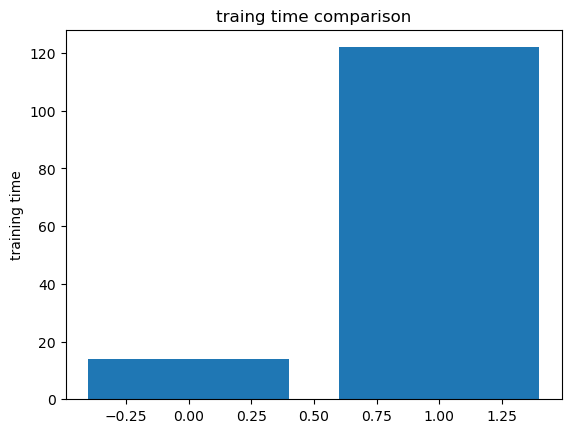

In [ ]:
time = [14, 122]
x = [0,1]
plt.bar(x,time)
plt.title("traing time comparison")
plt.ylabel("training time")

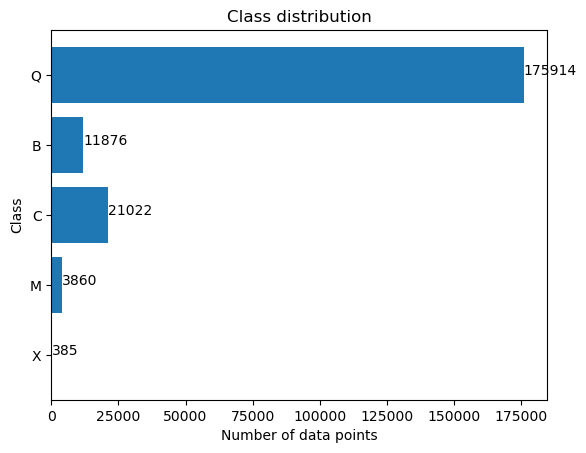

In [ ]:
import matplotlib.pyplot as plt
x = ["X", "M", "C", "B", "Q"]
y = [385, 3860, 21022, 11876, 175914]
plt.barh(x, y)
plt.title("Class distribution")
plt.xlabel("Number of data points")
plt.ylabel("Class")

for index, value in enumerate(y):
	plt.text(value, index,
			str(value))

plt.show()
